<a href="https://colab.research.google.com/github/mkorlyakova/keras/blob/master/Copy_of_Copy_of_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://github.com/ffeast/finam-export
!pip install -q finam-export

In [0]:
#from tensorflow.keras import utils #Утилиты для to_categorical
#from tensorflow.keras.preprocessing import image #Для отрисовки изображения

from keras.optimizers import Adam #Оптимизатор
from keras.models import Sequential, Model #Два варианты моделей
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, CuDNNLSTM,MaxPooling1D,MaxPooling2D #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики


from google.colab import files #Для загрузки своей картинки
import numpy as np #Библиотека работы с массивами
import matplotlib.pyplot as plt #Отрисовка изображений
#from PIL import Image #Отрисовка изображений
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline
import pandas as pd

In [0]:
from finam.export import Exporter, Market, LookupComparator

In [0]:
exporter = Exporter()

print('*** Отыскиваем символы на срочном рынке ***')
res = exporter.lookup(
    market=[Market.FUTURES_ARCHIVE, Market.FUTURES],
    name='RTS',
    name_comparator=LookupComparator.EQUALS)
#print(','.join(res['code']))
print(res['code'])


print('*** Скачиваем котировки {} ***'.format(','.join(res['code'])))
assert len(res) == 1
rawData = exporter.download(res.index[0], market=Market.FUTURES)
print(rawData)

*** Отыскиваем символы на срочном рынке ***
id
17455    RTS
Name: code, dtype: object
*** Скачиваем котировки RTS ***
              <OPEN>    <HIGH>     <LOW>   <CLOSE>   <VOL>
index                                                     
2007-01-09  190105.0  190105.0  176505.0  177400.0   37810
2007-01-10  178300.0  178300.0  172010.0  178250.0   43203
2007-01-11  177500.0  181645.0  176000.0  181105.0   40362
2007-01-12  180000.0  182000.0  178005.0  180295.0   38819
2007-01-15  182000.0  187080.0  182000.0  186495.0   50279
...              ...       ...       ...       ...     ...
2020-02-17  153540.0  154930.0  153540.0  154710.0  264203
2020-02-18  154700.0  154700.0  151000.0  152190.0  504312
2020-02-19  152240.0  154900.0  152240.0  154590.0  396143
2020-02-20  154520.0  155390.0  152270.0  153150.0  493192
2020-02-21  153100.0  153100.0  151510.0  152670.0  220614

[3291 rows x 5 columns]


In [0]:
print(type(rawData))

<class 'pandas.core.frame.DataFrame'>


In [0]:
# Дата в расчетах не нужна - убираем её и оставляем только значимые каналы
data = rawData.reset_index()
data = data.drop(columns=['index'],axis=1).values
print(data[:10])

[[190105. 190105. 176505. 177400.  37810.]
 [178300. 178300. 172010. 178250.  43203.]
 [177500. 181645. 176000. 181105.  40362.]
 [180000. 182000. 178005. 180295.  38819.]
 [182000. 187080. 182000. 186495.  50279.]
 [186300. 188620. 183700. 188500.  55603.]
 [184000. 186100. 180000. 181495.  50468.]
 [183100. 184900. 179500. 180000.  60535.]
 [179605. 182150. 178605. 181340.  64071.]
 [183850. 185935. 182255. 184700.  54227.]]


In [0]:
# Конфигурационные параметры 
# На сколько позиций вперед делать предсказание
forecast_days = 1
# Длина предсказанной последовательности
y_window_len = 1
# Длина окна обучающих данных, из которого формируются сэмплы
x_window_len = 5
# Какой лаг делаем между обучающими и тестовыми данными
test_train_lag = 2
# Размер тренировочной выборки
validation_ratio = .2

In [0]:
# Формируем сэмплы, на которых будет обучаться сеть
# Каждый сэмпл = window_len позиций назад * количество каналов по каждой позиции
def makeSamples(data,window_len,forecast_days,y_window_len=1):
  #i = 0
  channels_list = range(data.shape[1])
  #print (data[i:i + window_len,channels_list].flatten())
  x_samples = np.array([data[i:i + window_len,channels_list] for i in range(data.shape[0] - window_len + 1 - forecast_days)])
  # Канал 3 - <CLOSE>
  y_result = np.array([data[i:i+y_window_len,channels_list] for i in range(x_window_len,data.shape[0] - y_window_len + 1 - forecast_days)])

  return x_samples[:(-x_window_len)], y_result

In [0]:
# Нормализуем данные
def normalizeData(m_data, Normalization=0):
  print ('Размер исходного массива: ',m_data.shape)
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (Normalization == 0):
    scaler = StandardScaler()
  else:
    scaler = MinMaxScaler()
    
  resData = []

  #Берём только те каналы, которые указаны в аргументе функции
  #Обучаем нормировщик
  channels = range(m_data.shape[2])
    
  resData = np.stack([scaler.fit_transform(m_data[:,:,i].copy()) for i in range(m_data.shape[2])],axis=2)
  #Нормируем данные
  # Нужно возвращать нормировщик, чтобы провести обратное преобразование
  return np.array(resData), scaler

In [0]:
#scaler = StandardScaler()
#data = scaler.fit_transform(data.copy())

X_samples, Y_result = makeSamples(data,x_window_len,forecast_days,y_window_len)
print('Исходные данные: \n',data[:20])
print(data.shape)

print('Сэмплы (1-й элемент)')
print ('Y: \n',Y_result[0])
print(Y_result.shape)

print ('X: \n',X_samples[0])
print(X_samples.shape)


Исходные данные: 
 [[190105. 190105. 176505. 177400.  37810.]
 [178300. 178300. 172010. 178250.  43203.]
 [177500. 181645. 176000. 181105.  40362.]
 [180000. 182000. 178005. 180295.  38819.]
 [182000. 187080. 182000. 186495.  50279.]
 [186300. 188620. 183700. 188500.  55603.]
 [184000. 186100. 180000. 181495.  50468.]
 [183100. 184900. 179500. 180000.  60535.]
 [179605. 182150. 178605. 181340.  64071.]
 [183850. 185935. 182255. 184700.  54227.]
 [183700. 186610. 182700. 186500.  55285.]
 [189750. 189750. 184290. 185350.  51524.]
 [186005. 189490. 186000. 188440.  47127.]
 [186800. 187850. 185790. 186485.  29820.]
 [187895. 188500. 182650. 182695.  36816.]
 [181000. 183300. 178810. 183200.  53498.]
 [185000. 185900. 182600. 184895.  50477.]
 [187000. 190305. 186055. 189740.  60346.]
 [189985. 191035. 188100. 189950.  61655.]
 [190510. 191850. 188810. 190400.  53603.]]
(3291, 5)
Сэмплы (1-й элемент)
Y: 
 [[186300. 188620. 183700. 188500.  55603.]]
(3285, 1, 5)
X: 
 [[190105. 190105. 1765

In [0]:
print ('Перед нормировкой \n',X_samples[0])
X_samples, X_scaler = normalizeData(X_samples)
print ('После нормировки: \n',X_samples[0])
print('Размер нормализованного массива: ',X_samples.shape)

Перед нормировкой 
 [[190105. 190105. 176505. 177400.  37810.]
 [178300. 178300. 172010. 178250.  43203.]
 [177500. 181645. 176000. 181105.  40362.]
 [180000. 182000. 178005. 180295.  38819.]
 [182000. 187080. 182000. 186495.  50279.]]
Размер исходного массива:  (3281, 5, 5)
После нормировки: 
 [[ 1.4335207   1.3863065   1.14457265  1.11467461 -1.4316582 ]
 [ 1.13661051  1.09017226  1.03110497  1.13649564 -1.420639  ]
 [ 1.11683785  1.17458148  1.13248228  1.20888441 -1.42763808]
 [ 1.18023113  1.18389895  1.18362225  1.18884513 -1.43164209]
 [ 1.23105039  1.31207068  1.28525814  1.34571536 -1.40722857]]
Размер нормализованного массива:  (3281, 5, 5)


In [0]:
Y_result, Y_scaler = normalizeData(Y_result)
print (Y_result[0])
print ('Размер результирующего массива',Y_result.shape)

Размер исходного массива:  (3285, 1, 5)
[[ 1.33993795  1.35134899  1.32877308  1.39689122 -1.39591368]]
Размер результирующего массива (3285, 1, 5)


In [0]:
# Разделаем данные на обучающую и тестовую выборки с учётом лага и окна
dln = len(X_samples)
print ('Общее количество данных: ',dln)

# Длина обучающего набора
train_len = int(dln*(1-val_ratio))
print('Длина обучающей выборки: ',train_len)

# Длина тестового набора сделана так, чтобы не пересекаться с обучающей выборкой. 
# Для этого нужно учитывать окно и взять небольшой лаг
test_len = dln - train_len - x_window_len - test_train_lag
print('Длина тестовой выборки: ',test_len)

Общее количество данных:  3281
Длина обучающей выборки:  2624
Длина тестовой выборки:  650


In [0]:
X_train, Y_train = X_samples[:train_len],Y_result[:train_len]
print ('Размер X_train: ',X_train.shape)
print ('Размер Y_train: ',Y_train.shape)
Y_train = Y_train[:,0,3].copy()
Y_train = np.expand_dims(Y_train, axis=2)
print ('Размер Y_train: ',Y_train.shape)

Размер X_train:  (2624, 5, 5)
Размер Y_train:  (2624, 1, 5)
Размер Y_train:  (2624, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


In [0]:
X_test, Y_test = X_samples[-test_len:],Y_result[-test_len:]
print ('Размер X_test: ',X_test.shape)
print ('Размер Y_test: ',Y_test.shape)
Y_test = Y_test[:,0,3].copy()
Y_test = np.expand_dims(Y_test, axis=2)

print ('Размер Y_test: ',Y_test.shape)

Размер X_test:  (650, 5, 5)
Размер Y_test:  (650, 1, 5)
Размер Y_test:  (650, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


МОДЕЛЬ

In [0]:
modelC = Sequential()

print (X_train.shape)

print (Y_train1.shape)

print(X_train.shape[1],X_train.shape[2])

modelC.add(Conv1D(30, 3, input_shape=(X_train.shape[1],X_train.shape[2]), activation="linear",padding='same'))
modelC.add(MaxPooling1D(1))
modelC.add(Conv1D(10, 1, activation="linear",padding='same'))
modelC.add(MaxPooling1D(2))
modelC.add(Flatten())
modelC.add(Dropout(0.2))
modelC.add(Dense(2000, activation="relu"))
modelC.add(Dropout(0.2))
modelC.add(BatchNormalization())
modelC.add(Dense(Y_train.shape[1], activation="softmax"))

modelC.summary()

modelC.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelC.fit(X_train, 
                    Y_train, 
                    epochs=20, 
                    batch_size=20, 
                    verbose=1,
                    validation_split=validation_ratio)




(2624, 5, 5)
(2616, 1)
5 5
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_76 (Conv1D)           (None, 5, 30)             480       
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 5, 30)             0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5, 10)             310       
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 2, 10)             0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 20)                0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_79 (Dense)          

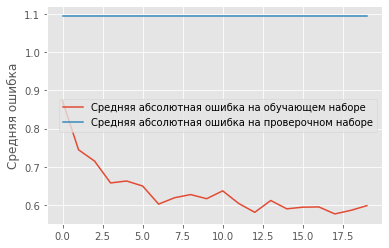

In [0]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [0]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xTestVal, yTestVal, yScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходны масштаб данных, до нормализации
  predY = yScaler.inverse_transform(currModel.predict(xTestVal))
  yTestUnscaled = yScaler.inverse_transform(yTestVal)
  
  return (predY, yTestUnscaled)

#Функция расчёта коэффициента корреляции Пирсона двух одномерных векторов
def correlate(a, b):
  return np.corrcoef(a, b)[0, 1] 



In [0]:
(predVal, yValUnscaled) = getPred(modelC,X_test,Y_test,Y_scaler)

(650, 1) (650, 1)


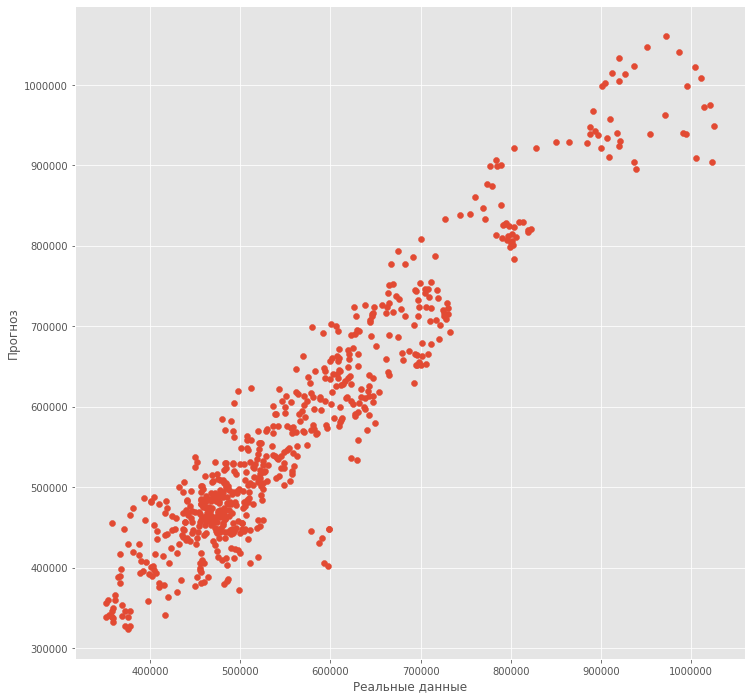

In [0]:
import matplotlib

matplotlib.style.use('ggplot')

print(predVal.shape,yValUnscaled.shape)

plt.figure(figsize=(12,12))
plt.scatter(predVal, yValUnscaled)
plt.ylabel('Прогноз')
plt.xlabel('Реальные данные')
plt.show()

In [0]:
#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(predVal, yValUnscaled):
  plt.figure(figsize=(12,12))
  plt.plot(predVal, 
           label='Прогноз')
  plt.plot(yValUnscaled, 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

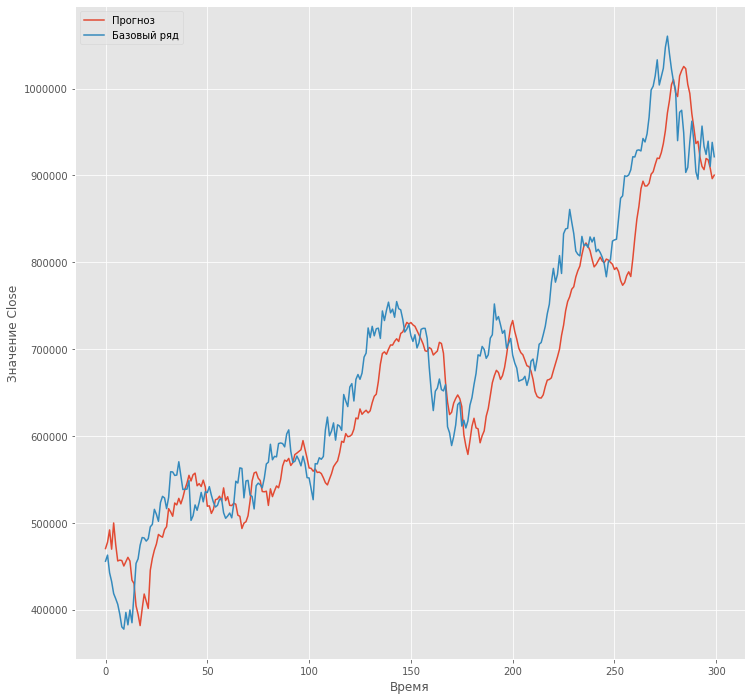

In [0]:
showPredict(predVal[-300:], yValUnscaled[-300:])

In [0]:
# Функция строит корреляцию прогнозированного сигнала с правильным
#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #Проходим по всем каналам
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки

    #Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      #Получаем сигнал, смещённый на i шагов назад
      #predVal[i:, ch]
      #Сравниваем его с верными ответами, без смещения назад
      #yValUnscaled[:yLen-i,ch]
      #Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    #Отображаем график корреляций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

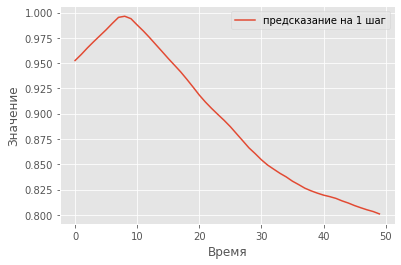

In [0]:
showCorr([0], 50, predVal, yValUnscaled)